In [35]:
%matplotlib inline
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from QSVM_kernel_utils import plot_bloch, plot_svc_decision_function, accuracy_score

This is the QSVM introductory task. We will focus on understanding conceptually what a QSVM hope to achieve.

First of all we show as a simple visual example the case of a classical SVM. The data will consist of 1 dimensional data.

In [36]:
data_classic = np.array([-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
labels_classic = np.array([0, 0, 0, 0 , 1, 1, 1, 1, 1, 0, 0, 0, 0])



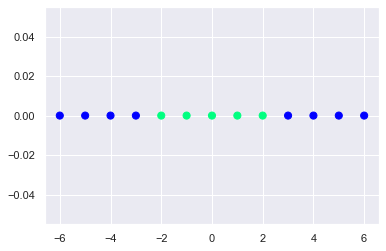

In [37]:
zero_array =  np.zeros(data_classic.size)
plt.scatter(data_classic, zero_array, c=labels_classic, s=50, cmap='winter')

This data is purely 1 dimensional. We now encode the data into a higher dimensional space, for example 2 dimensions.

In [38]:
labels_classic = np.transpose(labels_classic)
data_classic_plot = np.vstack([data_classic, zero_array])
data_classic_plot = np.transpose(data_classic_plot)

In [39]:
from sklearn.svm import SVC # "Support vector classifier"

model = SVC(kernel='linear', C=10)
model.fit(data_classic_plot, labels_classic)

SVC(C=10, kernel='linear')

Performing a SVM on this 1 dimensional data will result in a decision boundary that produces the following effect: 
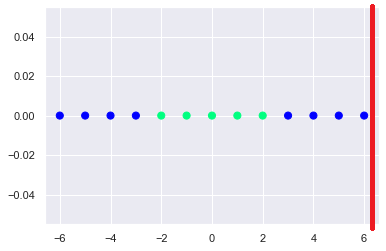

In [40]:
accuracy_score(model, data_classic_plot, labels_classic)
pred = model.predict(data_classic_plot)
print("Class predictions are : ",pred)

Accuracy score is  61.5 %
Class predictions are :  [0 0 0 0 0 0 0 0 0 0 0 0 0]


In this case the decision boundary is beyond the end of the data and all the data is simply labelled as class 0 (blue in this case).


We want to now implement a feature map which will take the data from 1 dimension to 2 dimensional space. We are going to implement this classically and explicitly. 

The data will be transformed from [x] to [x, f(x)] where f(x) is a function you need to write below.

We getting some of this code from https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html which have code avaliable under MIT license

In [48]:
def encoding_function(x):
    # enter code here
    # ==============
    # ==============
    
    # y = f(x)
    
    y =x**2
    
    
    # ==============
    # ==============
    return y

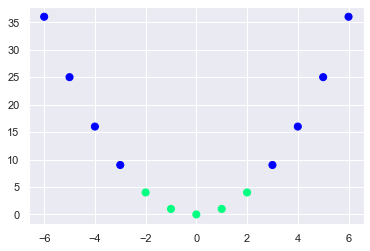

In [50]:
encoded_data = encoding_function(data_classic)

data_to_plot = np.vstack([data_classic, encoded_data])
data_to_plot = np.transpose(data_to_plot)
plt.scatter(data_to_plot[:, 0], data_to_plot[:, 1], c=labels_classic, s=50, cmap='winter')


Your encoding function should result in the points being plotted in 2D. If an appropriate encoding function was used then the points should now be seperable by a single straight line drawn on the graph. In order to test this run the next line.

Accuracy score is  100.0 %


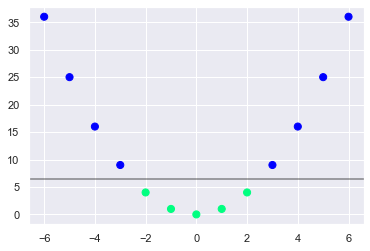

In [54]:
model = SVC(kernel='linear', C=1)
model.fit(data_to_plot, labels_classic)

plt.scatter(data_to_plot[:, 0], data_to_plot[:, 1], c=labels_classic, s=50, cmap='winter')
plot_svc_decision_function(model)
accuracy_score(model, data_to_plot, labels_classic)

Now we will transition over to considering the QSVM. With n qubits it is possible to encode classical data into a 2^n dimensional hilbert space. This higher dimensional space could allow better classification of the data.

We shall start with the most simple case, using 1 qubit only. This will allow the most intuitive understanding as it is effectively the same problem we have just seen classically. We will be encoding 1 dimensional classical data into the 2 dimensional hilbert space of a qubit, the separation is then performed here.

In [55]:
# Quantum packages
from qiskit.quantum_info import Statevector, Operator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import cmath

In [66]:
# Load up data
data_list = []
labels = [0, 1, 0, 1]
for index_x in range(4):
    variable = [(index_x + 1) * np.pi / 8]  
    data_list.append(variable)
data_list

[[0.39269908169872414],
 [0.7853981633974483],
 [1.1780972450961724],
 [1.5707963267948966]]

In [67]:
def kernel_circuit(x):

    # Initialise the quantum circuit
    sub_q = QuantumRegister(1, 'sub_q')
    sub_U = QuantumCircuit(sub_q, name='sub_U')


    # WRITE CODE HERE
    # ==================================
    # ==================================
    
    sub_U.ry(7 * x[0], sub_q[0])

    # ==================================
    # ==================================
    
    sub_inst_U = sub_U.to_instruction()

    return sub_inst_U

In [68]:
def get_statevector(x_data_array, quantum_circuit):
    
    #Input : x_data_array - An array containing all the classical datapoints
    #Output : statevector_array - An array containing the quantum statevector for each datapoint
    " The entire circuit is constructed here and the statevector generated"       
    statevector_array = [None] * len(x_data_array)

    num_qubits = 1

    for i in range(len(x_data_array)):

        sub_inst_U = quantum_circuit(x_data_array[i])
        
        qr = QuantumRegister(num_qubits, 'qr')
        cr = ClassicalRegister(num_qubits, 'cr')
        circ_U = QuantumCircuit(qr, cr)
        

   

        circ_U.append(sub_inst_U, qr)
            
        # Select the StatevectorSimulator from the Aer provider
        simulator = Aer.get_backend('statevector_simulator')
        # Execute and get counts
        result = execute(circ_U, simulator).result()
        statevector = result.get_statevector(circ_U)

        statevector_array[i] = statevector

    return statevector_array

In [69]:
def find_bloch_coordinates_from_statevector(statevector_array):
    
    #Input : statevector_array - An array consisting of th quantum statevectors corresponding to each datapoint
    # Output: theta, phi - Arrays containing the theta and phi coordinates for the bloch sphere representation of a statevector for each datapoint.
    alpha = statevector_array[:, 0]
    beta = statevector_array[:, 1]
    
    max_alpha = (max(abs(alpha)))
    theta = 2 * np.arccos(abs(alpha) / max(max_alpha, 1))
    
    phi = [0] * len(theta)
    for i in range(len(phi)):
        phi[i] = cmath.phase(beta[i]) - cmath.phase(alpha[i])
        phi = np.array(phi)
    theta = theta.reshape((len(theta), 1))
    phi = phi.reshape((len(phi), 1))
    return theta, phi

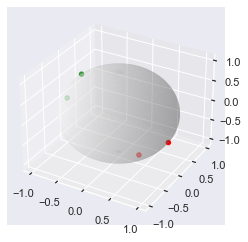

In [70]:
statevector_array = np.array(get_statevector(data_list, kernel_circuit))
theta, phi = find_bloch_coordinates_from_statevector(statevector_array)
plot_bloch(theta, phi, labels)

In this example we used basic rotational symmettery to collapse multiple datapoints to one point on the bloch sphere.

Now we turn to an example where a kernel will have to be calculated by trial and error in order to separete the points.


In [71]:
linspace = np.linspace(0, 2 * np.pi, num=100, endpoint = False)
data_list = []
for index_x in range(100):
    variable = [linspace[index_x]]  
    data_list.append(variable) 
labels = np.load("top_half.npy")

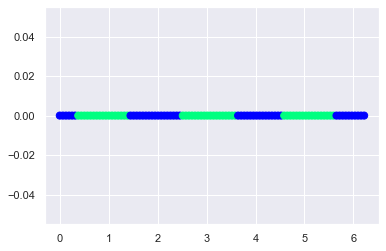

In [72]:
zero_array =  np.zeros(len(data_list))
plt.scatter(data_list, y=zero_array, c=labels, s=50, cmap='winter')

Write a basic kernel circuit that will project this line onto a ring around the bloch sphere.

In [73]:
def basic_kernel_circuit(x):
    
    # Links particles based on difference in 1st variable
    sub_q = QuantumRegister(1, 'sub_q')
    sub_U = QuantumCircuit(sub_q, name='sub_U')

    # YOUR CODE GOES HERE
    # ==================
    # ==================

    # Puts theta and p next to each other
    for theta_index in range(1):
        sub_U.rx(x[0], sub_q[0])
        
    # ==================
    # ==================
    
    sub_inst_U = sub_U.to_instruction()

    return sub_inst_U

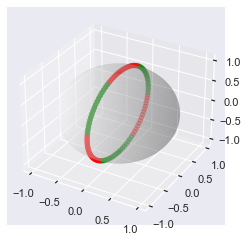

In [74]:
statevector_array = np.array(get_statevector(data_list, basic_kernel_circuit))
theta, phi = find_bloch_coordinates_from_statevector(statevector_array)
plot_bloch(theta, phi, labels)

In [75]:
def kernel_circuit_2(x):

    # Links particles based on difference in 1st variable
    sub_q = QuantumRegister(1, 'sub_q')
    sub_U = QuantumCircuit(sub_q, name='sub_U')

    # YOUR CODE GOES HERE
    # ==================
    # ==================
    
    pi_frac = np.pi /8
    theta = [1 * pi_frac, 1 * pi_frac, 1 * pi_frac]
    theta_2 = [3 * pi_frac, 3 * pi_frac, 3 * pi_frac]
    
    # Puts theta and p next to each other
    for theta_index in range(3):
        sub_U.rx(x[0], sub_q[0])
        
        
        sub_U.ry(theta[theta_index], sub_q[0])
        sub_U.rx(theta_2[theta_index], sub_q[0])
        
    # ==================
    # ==================
    
    sub_inst_U = sub_U.to_instruction()

    return sub_inst_U

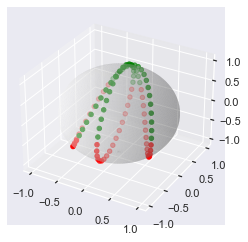

In [76]:
statevector_array = np.array(get_statevector(data_list, kernel_circuit_2))
theta, phi = find_bloch_coordinates_from_statevector(statevector_array)
plot_bloch(theta, phi, labels)